# Requirements

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd

import sddk

# PLOTTING
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import geoplot as gplt

In [114]:
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")
figpath = "SDAM_data/social_diversity/socdiv_figures/"

# global parameters for plots
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    #each figure to be saved in four different versions
    fig.savefig("../figures/" + fig_name + ".eps", format="eps")
    fig.savefig("../figures/" + fig_name + ".png")
    s.write_file(figpath + fig_name + ".eps", fig)
    s.write_file(figpath + fig_name + ".png", fig)

connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


# Import datasets

In [5]:
LIRE = gpd.read_parquet("../data/large_data/LIRE_occupsorgs_cats.parquet")

In [6]:
# mask
before235 = LIRE["not_before"] < 235

In [7]:
LIRE[LIRE["is_western"]]

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats
219,EDCS-21300235,"CIL 06, 00882 (p 3777, 4302, 4367) = CIL 06, 3...",Aegyptus,Aegyptus,Al Iskandariyah / Alexandria,"['Al Iskandariyah', 'Alexandria']",20,,"['Augusti/Augustae', 'tituli sacri', 'viri']",tituli sacri,...,9998.65,1002,"[12.395451, 42.021684]",15756.86,large,[faber],1,[],0,"[Production and related workers, transport equ..."
290,EDCS-12800362,"AE 1964, 00222",Aemilia / Regio VIII,Aemilia / Regio VIII,Bagno di Romagna,Bagno di Romagna,200,,"['tituli sacri', 'viri']",tituli sacri,...,41767.45,937,"[11.903398, 43.983123]",17068.12,rural,[],0,[],0,[]
291,EDCS-09300206,"AE 1976, 00204",Aemilia / Regio VIII,Aemilia / Regio VIII,Bologna / Bononia,"['Bologna', 'Bononia']",50,,"['mulieres', 'tituli sepulcrales', 'tria nomin...",tituli sepulcrales,...,330.60,1012,"[11.470525, 44.443585]",11359.10,medium,[],0,[],0,[]
292,EDCS-09300210,"AE 1976, 00208",Aemilia / Regio VIII,Aemilia / Regio VIII,Bologna / Bononia,"['Bologna', 'Bononia']",50,,"['liberti/libertae', 'mulieres', 'tituli sepul...",tituli sepulcrales,...,330.60,1012,"[11.470525, 44.443585]",11359.10,medium,[],0,[],0,[]
293,EDCS-09300215,"AE 1976, 00213",Aemilia / Regio VIII,Aemilia / Regio VIII,Bologna / Bononia,"['Bologna', 'Bononia']",100,,"['mulieres', 'tituli sepulcrales', 'tria nomin...",tituli sepulcrales,...,330.60,1012,"[11.470525, 44.443585]",11359.10,medium,[],0,[],0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137300,EDCS-10700071,"SupIt-12-IC, 00047 = IulCarnicum-02, 00125",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",200,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]
137301,EDCS-10700072,"SupIt-12-IC, 00048 = IulCarnicum-02, 00137",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",200,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]
137302,EDCS-10700073,"SupIt-12-IC, 00049 = IulCarnicum-02, 00134",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",200,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]
137303,EDCS-10700074,"SupIt-12-IC, 00050 = IulCarnicum-02, 00115",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",25,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]


In [8]:
LIRE.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,...,37687.28,31,"[20.787767, 39.546432]",10725.84,rural,[],0,[],0,[]
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,...,23430.85,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[]
2,EDCS-28500283,"CIL 03, 07251 = D 00214 = NDIEC-07, p 81 = AE ...",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",50,,"['Augusti/Augustae', 'leges', 'viri']",leges,...,23430.85,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[]
3,EDCS-09400671,"CIMRM-02, 02350 = IG-12, 00274 = Andros 00124 ...",Achaia,Achaia,Andros,Andros,209,,"['litterae erasae', 'tituli sacri']",tituli sacri,...,60414.04,47,"[24.34625, 37.633122]",47547.59,rural,[],0,[],0,[]
4,EDCS-24600769,"AE 1995, 01407 = AE 2001, 01812",Achaia,Achaia,Archea Olimpia / Archaia Olympia / Olympia,"['Archea Olimpia', 'Archaia Olympia', 'Olympia']",96,,{ },{ },...,45272.69,35,"[21.435443, 37.827452]",26125.55,large,[],0,[],0,[]


In [9]:
len(LIRE[before235])

115926

In [10]:
LIRE[before235]["occups_N"].sum()

4810

In [11]:
LIRE[before235]["occups_N"].sum() / LIRE["occups_N"].sum()

0.9172387490465294

In [12]:
roman_cities = gpd.read_file("../data/roman_cities_pop.geojson")
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson")
pleiades_regions_west = gpd.read_file("../data/pleiades_regions_west.geojson")

# Map inscriptions on cities

In [13]:
def get_my_city(row):
    context = row["urban_context_alt"]
    try:
        ID = row[context + "_city_ID"]
    except:
        ID = None
    return ID
LIRE["city_ID"] = LIRE.apply(lambda row: get_my_city(row), axis=1)

In [14]:
def get_inscriptions(ID):
    city_dict = {}
    city_data = LIRE[LIRE["city_ID"]==str(ID)]
    if len(city_data) > 0:
        city_dict["inscr_N"] = len(city_data)
        inscr_texts = city_data["clean_text_interpretive_word"].tolist()
        inscr_texts = [el for el in inscr_texts if isinstance(el, str)]
        city_dict["inscr_texts_wordlist"] = " ".join(inscr_texts).split()
        city_dict["edcs_ids"] = city_data["EDCS-ID"].tolist()
        city_dict["edh_ids"] = city_data["EDH-ID"].tolist()
        city_dict["inscr_with_occups"] = (city_data["occups_N"]>0).sum()
        city_dict["occups_mask"] = city_data["occups_N"] > 0
        city_dict["occups_list"] = [el for sublist in city_data["occups"] for el in sublist]
        city_dict["occups_N"] = city_data["occups_N"].sum()
        city_dict["occups_cats_list"] = [el for sublist in city_data["occups_cats"] for el in sublist]
    return city_dict

cities_dict_data = roman_cities["ID"].apply(get_inscriptions)

In [15]:
cities_inscr_data = pd.DataFrame(cities_dict_data.tolist())
cities_inscr_data.head(5)

,inscr_N,inscr_texts_wordlist,edcs_ids,edh_ids,inscr_with_occups,occups_mask,occups_list,occups_N,occups_cats_list
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,"[Caius, Varius, Stratullus, Γάϊος, Οὐάριος, Στ...",[EDCS-45800005],[HD006767],0.0,"192 False Name: occups_N, dtype: bool",[],0.0,[]
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
roman_cities = pd.concat([roman_cities, cities_inscr_data], axis=1)

In [17]:
del cities_inscr_data
del cities_dict_data

# Explore inscriptions within cities

In [18]:
roman_cities.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,geometry,inscr_N,inscr_texts_wordlist,edcs_ids,edh_ids,inscr_with_occups,occups_mask,occups_list,occups_N,occups_cats_list
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,...,POINT (22.93333 38.58333),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,BNP; DGRG; PECS; Sear 2006.,...,POINT (23.73409 38.08347),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,...,POINT (23.21970 38.45261),1.0,"[Caius, Varius, Stratullus, Γάϊος, Οὐάριος, Στ...",[EDCS-45800005],[HD006767],0.0,"192 False Name: occups_N, dtype: bool",[],0.0,[]
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,...,POINT (23.42850 37.75007),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,DGRG; Hansen and Nielsen 2004.,...,POINT (22.35572 38.14795),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# all cities
len(roman_cities)

1388

In [20]:
roman_cities["inscr_N"].sum()

110163.0

In [21]:
# cities with at least one inscription
(roman_cities["inscr_N"]>0).sum()

856

In [22]:
# proportion of cities with at least one inscription
(roman_cities["inscr_N"]>0).mean()

0.6167146974063401

In [23]:
# N western cities
(roman_cities["western_province"]).sum()

889

In [24]:
((roman_cities["western_province"]) & (roman_cities["inscr_N"]>0)).sum()

657

In [25]:
((roman_cities["western_province"]) & (roman_cities["inscr_N"]>0)).sum() / (roman_cities["western_province"]).sum()

0.7390326209223848

# Focus on western cities alone - basic explorations (feel free to skip)

In [26]:
roman_cities = roman_cities[roman_cities["western_province"]]
len(roman_cities)

889

In [27]:
roman_cities["pop_est_log"] = np.log(roman_cities["pop_est"])
roman_cities["inscr_N_log"] = np.log(roman_cities["inscr_N"])

roman_cities["pop_est_log10"] = np.log10(roman_cities["pop_est"])
roman_cities["inscr_N_log2"] = np.log2(roman_cities["inscr_N"])

roman_cities["occups_N_log"] = np.log2(roman_cities["occups_N"])


/Users/kasev/Projects/social_diversity/socdiv_venv/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Measuring Specialization and Diversity

In [28]:
len(roman_cities)

889

In [29]:
(roman_cities["occups_N"]>0).sum()

313

In [30]:
roman_cities["occups_N"].max()

1855.0

In [31]:
# roman cities western with at least one occupations
roman_cities_wo = roman_cities[roman_cities["occups_N"]>0].copy()

In [32]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,inscr_with_occups,occups_mask,occups_list,occups_N,occups_cats_list,pop_est_log,inscr_N_log,pop_est_log10,inscr_N_log2,occups_N_log
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,1.0,"54970 True Name: occups_N, dtype: bool",[curator],1.0,[Administrative and managerial workers],6.907755,0.000000,3.000000,0.000000,0.000000
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,5.0,879 False 880 False 882 False 8...,"[scaenicus, curator, tonsor, possessor, faber]",5.0,"[Professional, technical and related workers, ...",8.905987,3.806662,3.867821,5.491853,2.321928
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,9.0,857 False 858 False 859 False 8...,"[curator, mesor, curator, mensor, agrimensor, ...",9.0,"[Administrative and managerial workers, Profes...",11.533453,6.163315,5.008915,8.891784,3.169925
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,1.0,1115 False 1116 False 1117 False 1118...,[sartor],1.0,"[Agricultural, animal husbandry and forestry w...",6.907755,2.639057,3.000000,3.807355,0.000000
177,Hanson2016_178,Hadrumetum,Sousse,Africa Proconsularis,Tunisia,3,33 G1,-150,NaN,BNP; Brunt 1971; DGRG; Lepelley 1979-1981; Mac...,...,1.0,875 False 1133 False 1387 False 1...,"[faber, faber]",2.0,"[Production and related workers, transport equ...",10.480803,2.564949,4.551755,3.700440,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Hanson2016_1298,Catania,Catania,Sicilia,Italy,3,47 G3,-729,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,1.0,49004 False 49005 False 49006 Fals...,[faber],1.0,"[Production and related workers, transport equ...",10.247432,4.787492,4.450403,6.906891,0.000000
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,1.0,49009 False 49010 False 49011 Fals...,[faber],1.0,"[Production and related workers, transport equ...",9.351579,1.791759,4.061339,2.584963,0.000000
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,1.0,49012 False 128502 False 128503 Fals...,"[curator, curator]",2.0,"[Administrative and managerial workers, Admini...",8.521584,3.367296,3.700877,4.857981,1.000000
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,1.0,128341 False 128342 False 128343 Fals...,[forensis],1.0,[Administrative and managerial workers],8.405367,3.332205,3.650405,4.807355,0.000000


In [33]:
# generate a dictionary of occupations by type
occupations_df = pd.read_csv("../data/occupations_list_hisco.csv")
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Harris_Category"]))

In [34]:
print(len(set(occups_cats_dict.values())))
set(occups_cats_dict.values())

19


{'Building',
 'Clothing',
 'Death-care sector',
 'Education',
 'Finance',
 'Food-Production',
 'Food-Retail',
 'Fuel / Raw material',
 'Glass-Working',
 'Household Goods',
 'Managerial',
 'Metal-Working',
 'Miscellaneous Services',
 'Performing Arts',
 'Plastic Arts',
 'Retail',
 'Transport',
 'Unclear meaning',
 'Water-Management'}

In [35]:
occups_cats_labels = list(set(occups_cats_dict.values()))
occups_cats_labels

['Education',
 'Building',
 'Clothing',
 'Fuel / Raw material',
 'Food-Retail',
 'Water-Management',
 'Unclear meaning',
 'Retail',
 'Transport',
 'Miscellaneous Services',
 'Glass-Working',
 'Plastic Arts',
 'Food-Production',
 'Metal-Working',
 'Performing Arts',
 'Managerial',
 'Finance',
 'Household Goods',
 'Death-care sector']

In [36]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
roman_cities_wo["occups_cats_list"] = roman_cities_wo["occups_list"].apply(cat_for_occup)

In [37]:
roman_cities_wo["occups_cats_unique_N"] = roman_cities_wo["occups_cats_list"].apply(lambda x: len(set(x)))
roman_cities_wo["occups_cats_unique_N"]

159     1
165     4
171     3
174     1
177     1
       ..
1297    1
1311    1
1315    1
1317    1
1321    1
Name: occups_cats_unique_N, Length: 313, dtype: int64

Text(0, 0.5, 'N cities')

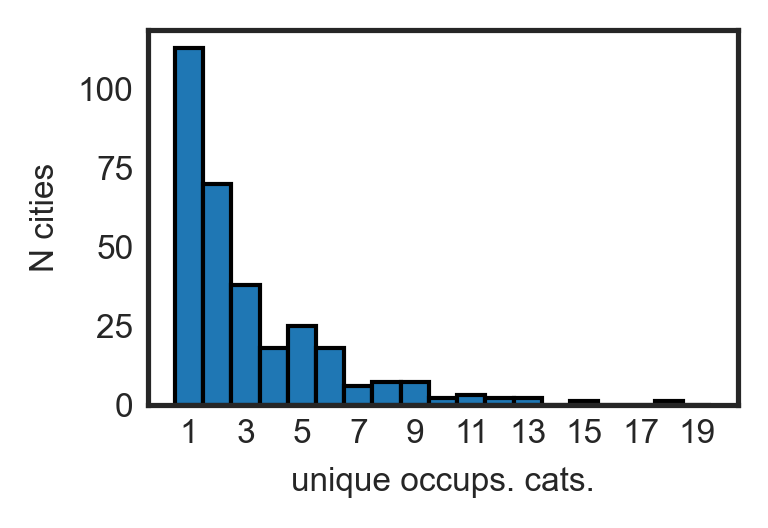

In [38]:
fig, ax = plt.subplots(figsize=(2.6, 1.8), tight_layout=True)
bins = [n+0.5 for n in range(0,20)]
roman_cities_wo["occups_cats_unique_N"].hist(ax=ax, edgecolor="black", bins=bins)
ax.set_xticks(range(1,20, 2))
ax.grid(False)
ax.set_xlabel("unique occups. cats.")
ax.set_ylabel("N cities")

In [39]:
save_figure(fig, "unique_cats_per_cities_hist")

A file with the same name ("unique_cats_per_cities_hist.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/unique_cats_per_cities_hist.eps"
A file with the same name ("unique_cats_per_cities_hist.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/unique_cats_per_cities_hist.png"


In [40]:
roman_cities_wo["occups_cats_unique_N"]

159     1
165     4
171     3
174     1
177     1
       ..
1297    1
1311    1
1315    1
1317    1
1321    1
Name: occups_cats_unique_N, Length: 313, dtype: int64

In [42]:
roman_cities_wo["occups_cats_list"]

159                                          [Managerial]
165     [Performing Arts, Managerial, Miscellaneous Se...
171     [Managerial, Miscellaneous Services, Manageria...
174                              [Miscellaneous Services]
177                        [Metal-Working, Metal-Working]
                              ...                        
1297                                      [Metal-Working]
1311                                      [Metal-Working]
1315                             [Managerial, Managerial]
1317                                         [Managerial]
1321                             [Managerial, Managerial]
Name: occups_cats_list, Length: 313, dtype: object

# Specialization

In [43]:
def get_cat_row_vec(cat_list):
    cat_row_vec = []
    for cat in occups_cats_labels:
        cat_row_vec.append(cat_list.count(cat))
    return np.array(cat_row_vec)

In [44]:
roman_cities_wo["occups_cats_vec"] = roman_cities_wo["occups_cats_list"].apply(get_cat_row_vec)
roman_cities_wo["occups_cats_vec"]

159     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
165     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, ...
171     [0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 1, 0, ...
174     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
177     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, ...
                              ...                        
1297    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
1311    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
1315    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1317    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1321    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: occups_cats_vec, Length: 313, dtype: object

In [45]:
def occups_cats_vec_weighted(occups_cat_vec):
    a = np.array(occups_cat_vec, dtype=float)
    a = a / sum(a)
    return a
roman_cities_wo["shares_vec"] = roman_cities_wo["occups_cats_vec"].apply(occups_cats_vec_weighted)
roman_cities_wo["shares_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
165     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
171     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
177     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_vec, Length: 313, dtype: object

In [46]:
roman_cities_wo["ZI"] = roman_cities_wo["shares_vec"].apply(max)
roman_cities_wo["ZI"]

159     1.000000
165     0.400000
171     0.666667
174     1.000000
177     1.000000
          ...   
1297    1.000000
1311    1.000000
1315    1.000000
1317    1.000000
1321    1.000000
Name: ZI, Length: 313, dtype: float64

In [47]:
roman_cities_wo["ZI_cat"] = roman_cities_wo["shares_vec"].apply(lambda x: occups_cats_labels[np.argmax(x)])
roman_cities_wo["ZI_cat"]

159                 Managerial
165                 Managerial
171     Miscellaneous Services
174     Miscellaneous Services
177              Metal-Working
                 ...          
1297             Metal-Working
1311             Metal-Working
1315                Managerial
1317                Managerial
1321                Managerial
Name: ZI_cat, Length: 313, dtype: object

In [119]:
roman_cities_wo.sort_values("ZI", ascending=False)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI_cat,shares_weighted_vec,RZI,RZI_cat,shares_squared_vec,ZI2,ZI2_cat,RZI2,DI,RDI
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,Managerial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.220963,Managerial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,Managerial,4.220963,1.000000,-2.058788e+16
605,Hanson2016_606,Cabillonum,Chalon sur Saône,Gallia Lugdunensis,France,4 or 5,18 B3,-27,NaN,BNP; DGRG; PECS.,...,Miscellaneous Services,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.550676,Miscellaneous Services,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,Miscellaneous Services,7.550676,1.000000,-2.058788e+16
855,Hanson2016_856,Grumentum,Grumento,Italia (III Lucania et Brutii),Italy,3,45 C4,-400,NaN,Beloch 1880; BNP; de Ligt 2012; DGRG; Golvin 1...,...,Managerial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.220963,Managerial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.000000,Managerial,8.441926,1.000000,-2.058788e+16
862,Hanson2016_863,Potentia (Italia (III Lucania et Brutii)),Potenza,Italia (III Lucania et Brutii),Italy,3,45 C3,-400,NaN,Beloch 1880; Bispham 2007; de Ligt 2012; DGRG.,...,Managerial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.220963,Managerial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,Managerial,4.220963,1.000000,-2.058788e+16
871,Hanson2016_872,Aequi,Aequi,Italia (IV Samnium),Italy,3,42 E4,-400,NaN,Beloch 1880; de Ligt 2012; Sear 2006.,...,Managerial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.220963,Managerial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,Managerial,4.220963,1.000000,-2.058788e+16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,Hanson2016_790,Pompeii,Pompei,Italia (I Latium and Campania),Italy,3,44 F4,-600,79.0,Beloch 1880; Beloch 1886; Benario 1981; Bispha...,...,Miscellaneous Services,"[0.0, 0.8343703334992533, 0.8257389162561577, ...",4.327668,Performing Arts,"[0.0, 0.16071428571428573, 0.16071428571428573...",1.785714,Miscellaneous Services,38.949010,7.919192,-4.803840e+16
1268,Hanson2016_1269,Brigetio,Szöny,Pannonia Inferior,Hungary,3,20 F2,50,NaN,BNP; DGRG; PECS; Salmon 1969; Wilkes 2003b; Wi...,...,Clothing,"[0.0, 0.0, 2.720081135902637, 0.0, 0.0, 0.0, 0...",4.961154,Plastic Arts,"[0.0, 0.0, 0.5294117647058824, 0.0, 0.0, 0.0, ...",0.529412,Clothing,8.160243,7.410256,1.441152e+17
785,Hanson2016_786,Norba,Norma,Italia (I Latium and Campania),Italy,3,43 D3,-600,-82.0,Beloch 1880; Beloch 1886; Cornell and Mathews ...,...,Building,"[0.0, 2.59581881533101, 0.0, 0.0, 6.8981481481...",6.898148,Food-Retail,"[0.0, 0.3333333333333333, 0.0, 0.0, 0.08333333...",0.333333,Building,7.028302,7.200000,-1.601280e+16
1045,Hanson2016_1046,Ateste,Este,Italia (X Venetia et Histria),Italy,4 or 5,40 B2,-400,NaN,Beloch 1880; Cornell and Mathews 1982; de Ligt...,...,Transport,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.601...",20.694444,Household Goods,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.166...",0.166667,Transport,20.694444,6.000000,-1.801440e+16


0.0

In [140]:
roman_cities_wo["ZIw"] = roman_cities_wo.apply(lambda row: row["ZI"] * row["occups_N_log"], axis=1)
roman_cities_wo.sort_values("ZIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N", "ZI", "ZIw"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,ZI,ZIw
724,Saguntum,351.0,22.0,1,1.000000,4.459432
1287,Augusta Vindelicum,210.0,10.0,2,0.900000,2.989735
873,Alba Fucentia,82.0,12.0,3,0.833333,2.987469
991,Roma,39887.0,1855.0,18,0.266846,2.897205
1058,Patavium,175.0,17.0,3,0.705882,2.885268
...,...,...,...,...,...,...
649,Mauves,4.0,1.0,1,1.000000,0.000000
631,Aquae Sextiae,24.0,1.0,1,1.000000,0.000000
605,Cabillonum,28.0,1.0,1,1.000000,0.000000
596,Agedincum,3.0,1.0,1,1.000000,0.000000


In [48]:
# Total shares
all_occups_N = roman_cities_wo["occups_N"].sum()
index_label_sum_dict = {}
for i, cat in zip(range(len(occups_cats_labels)), occups_cats_labels):
    cat_sum = sum(roman_cities_wo["occups_cats_vec"].apply(lambda vec: vec[i]))
    cat_share = cat_sum / all_occups_N
    index_label_sum_dict[i] = [cat, cat_sum, cat_share]
index_label_sum_dict

{0: ['Education', 216, 0.04832214765100671],
 1: ['Building', 287, 0.06420581655480985],
 2: ['Clothing', 290, 0.06487695749440715],
 3: ['Fuel / Raw material', 1, 0.00022371364653243848],
 4: ['Food-Retail', 54, 0.012080536912751677],
 5: ['Water-Management', 14, 0.003131991051454139],
 6: ['Unclear meaning', 4, 0.0008948545861297539],
 7: ['Retail', 303, 0.06778523489932886],
 8: ['Transport', 133, 0.029753914988814318],
 9: ['Miscellaneous Services', 592, 0.13243847874720358],
 10: ['Glass-Working', 8, 0.0017897091722595079],
 11: ['Plastic Arts', 53, 0.01185682326621924],
 12: ['Food-Production', 212, 0.04742729306487696],
 13: ['Metal-Working', 974, 0.21789709172259508],
 14: ['Performing Arts', 166, 0.03713646532438479],
 15: ['Managerial', 1059, 0.23691275167785236],
 16: ['Finance', 68, 0.015212527964205816],
 17: ['Household Goods', 36, 0.008053691275167786],
 18: ['Death-care sector', 0, 0.0]}

In [49]:
total_shares = np.array([val[2] for val in index_label_sum_dict.values()])
total_shares

array([4.83221477e-02, 6.42058166e-02, 6.48769575e-02, 2.23713647e-04,
       1.20805369e-02, 3.13199105e-03, 8.94854586e-04, 6.77852349e-02,
       2.97539150e-02, 1.32438479e-01, 1.78970917e-03, 1.18568233e-02,
       4.74272931e-02, 2.17897092e-01, 3.71364653e-02, 2.36912752e-01,
       1.52125280e-02, 8.05369128e-03, 0.00000000e+00])

In [50]:
def get_shares_weighted(vec):
    a = np.array(vec, dtype=float)
    b = total_shares
    shares_weighted =  np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    return shares_weighted

roman_cities_wo["shares_weighted_vec"] = roman_cities_wo["shares_vec"].apply(lambda vec: get_shares_weighted(vec))
roman_cities_wo["shares_weighted_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
165     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
171     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
177     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_weighted_vec, Length: 313, dtype: object

In [51]:
roman_cities_wo["RZI"] = roman_cities_wo["shares_weighted_vec"].apply(max)
roman_cities_wo["RZI"]

159     4.220963
165     5.385542
171     5.033784
174     7.550676
177     4.589322
          ...   
1297    4.589322
1311    4.589322
1315    4.220963
1317    4.220963
1321    4.220963
Name: RZI, Length: 313, dtype: float64

In [52]:
roman_cities_wo["RZI_cat"] = roman_cities_wo["shares_weighted_vec"].apply(lambda x: index_label_sum_dict[np.argmax(x)][0])
roman_cities_wo["RZI_cat"]

159                 Managerial
165            Performing Arts
171     Miscellaneous Services
174     Miscellaneous Services
177              Metal-Working
                 ...          
1297             Metal-Working
1311             Metal-Working
1315                Managerial
1317                Managerial
1321                Managerial
Name: RZI_cat, Length: 313, dtype: object

In [53]:
roman_cities_wo.sort_values("RZI", ascending=False)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,inscr_N_log2,occups_N_log,occups_cats_unique_N,occups_cats_vec,shares_vec,ZI,ZI_cat,shares_weighted_vec,RZI,RZI_cat
966,Hanson2016_967,Castrum Novum (Italia (VII Etruria)),Torre Chiaruccia,Italia (VII Etruria),Italy,3,44 A1,-400,NaN,Beloch 1880; BNP; Cornell and Mathews 1982; de...,...,4.754888,0.000000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,Plastic Arts,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",84.339623,Plastic Arts
1053,Hanson2016_1054,Iulium Carnicum,Zuglio,Italia (X Venetia et Histria),Italy,4 or 5,19 F3,-50,NaN,Beloch 1880; de Ligt 2012; PECS; Salmon 1969; ...,...,6.539159,0.000000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,Finance,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",65.735294,Finance
695,Hanson2016_696,Clunia,Peñalba de Castro,Hispania Tarraconensis,Spain,2,25 B4,14,NaN,BNP; Carreras Monfort 1995-1996; DGRG; PECS; S...,...,7.900867,1.000000,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,Building,"[0.0, 7.787456445993031, 0.0, 0.0, 0.0, 0.0, 0...",42.169811,Plastic Arts
660,Hanson2016_661,Colonia Ulpia Traiana,Xanten,Germania Inferior,Germany,3,11 G1,14,NaN,Benario 1981; Golvin 1988; McEvedy 2011; PECS;...,...,7.499846,1.000000,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,Miscellaneous Services,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",42.169811,Plastic Arts
1010,Hanson2016_1011,Caesena,Cesena,Italia (VIII Aemilia),Italy,4 or 5,40 C4,-200,NaN,Beloch 1880; de Ligt 2012; PECS.,...,4.000000,1.584963,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.666667,Managerial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",41.388889,Household Goods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,Hanson2016_958,Urvinum Mataurense,Urbino,Italia (VI Umbria and Ager Gallicus),Italy,3,42 D1,-400,NaN,Beloch 1880; Bispham 2007; BNP; de Ligt 2012; ...,...,5.857981,2.807355,4,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, ...","[0.0, 0.14285714285714285, 0.14285714285714285...",0.428571,Metal-Working,"[0.0, 2.2249875559980086, 2.2019704433497536, ...",2.224988,Building
844,Hanson2016_845,Venusia,Venosa,Italia (II Apulia et Calabria),Italy,3,45 C3,-400,NaN,Beloch 1880; Bispham 2007; BNP; Cornell and Ma...,...,8.479780,3.321928,5,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 3, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, ...",0.300000,Metal-Working,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.47524752...",2.108491,Food-Production
872,Hanson2016_873,Aesernia,Isernia,Italia (IV Samnium),Italy,3,44 F2,-400,NaN,Beloch 1880; Bispham 2007; BNP; Cornell and Ma...,...,7.781360,3.906891,5,"[1, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 5, 0, ...","[0.06666666666666667, 0.0, 0.13333333333333333...",0.333333,Metal-Working,"[1.3796296296296298, 0.0, 2.0551724137931036, ...",2.055172,Clothing
746,Hanson2016_747,Aquinum,Aquino,Italia (I Latium and Campania),Italy,2,44 E3,-400,NaN,Beloch 1880; Bispham 2007; Cornell and Mathews...,...,8.614710,5.209453,8,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 13, 1,...","[0.0, 0.02702702702702703, 0.02702702702702703...",0.459459,Managerial,"[0.0, 0.420943591675299, 0.4165890027958994, 0...",1.939361,Managerial


In [126]:
roman_cities_wo["RZIw"] = roman_cities_wo.apply(lambda row: row["RZI"] * row["occups_N_log"], axis=1)
roman_cities_wo.sort_values("RZIw", ascending=False)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,RZI,RZI_cat,shares_squared_vec,ZI2,ZI2_cat,RZI2,DI,RDI,ZIw,RZIw
659,Hanson2016_660,Colonia Agrippinensis,Cologne,Germania Inferior,Germany,2,11 G2,-38,NaN,Bedon 2001; Bedon et al 1988; Benario 1981; Mc...,...,30.202703,Unclear meaning,"[0.02702702702702703, 0.24324324324324326, 0.0...",4.567568,Retail,67.382927,5.587755,1.441152e+17,1.830348,157.339571
1276,Hanson2016_1277,Carnuntum (1),Petronell,Pannonia Superior,Austria,3,13 B4,15,NaN,BNP; DGRG; Golvin 1988; McEvedy 2011; PECS; Wi...,...,31.041667,Glass-Working,"[0.05555555555555555, 0.05555555555555555, 0.2...",0.888889,Miscellaneous Services,31.041667,7.043478,-9.607679e+15,0.926650,129.441422
1277,Hanson2016_1278,Carnuntum (2),Petronell,Pannonia Superior,Austria,3,13 B4,103,NaN,Benario 1981; BNP; Boatwright 2000; Golvin 198...,...,39.910714,Water-Management,"[0.0, 0.125, 0.125, 0.0, 0.0, 0.125, 0.0, 0.12...",0.500000,Metal-Working,39.910714,6.400000,-2.058788e+16,0.750000,119.732143
663,Hanson2016_664,Andematunum,Langres,Germania Superior,France,3,18 C2,-27,NaN,Bedon 2001; Bedon et al 1988; BNP; DGRG; PECS;...,...,20.694444,Food-Retail,"[0.0, 0.16666666666666666, 0.0, 0.0, 1.5, 0.0,...",1.500000,Food-Retail,124.166667,6.000000,-8.477364e+15,1.146241,94.883252
666,Hanson2016_667,Argentoratum,Strasbourg,Germania Superior,France,3,11 H4,80,NaN,McEvedy 2011; Russell 1958; Sear 2006; Wilson ...,...,33.735849,Plastic Arts,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.800000,Plastic Arts,67.471698,2.777778,1.601280e+16,0.928771,78.332216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,Hanson2016_650,Mauves,Mauves,Gallia Narbonensis,France,4 or 5,14 D1,-27,NaN,PECS; Sear 2006.,...,33.609023,Transport,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1.000000,Transport,33.609023,1.000000,-2.058788e+16,0.000000,0.000000
631,Hanson2016_632,Aquae Sextiae,Aix en Provence,Gallia Narbonensis,France,3,15 E2,-27,NaN,Bedon 2001; Bedon et al 1988; MacMullen 2000; ...,...,15.574913,Building,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,Building,15.574913,1.000000,1.601280e+16,0.000000,0.000000
605,Hanson2016_606,Cabillonum,Chalon sur Saône,Gallia Lugdunensis,France,4 or 5,18 B3,-27,NaN,BNP; DGRG; PECS.,...,7.550676,Miscellaneous Services,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,Miscellaneous Services,7.550676,1.000000,-2.058788e+16,0.000000,0.000000
596,Hanson2016_597,Agedincum,Sens,Gallia Lugdunensis,France,4 or 5,11 D4,-27,NaN,Bedon 2001; Bedon et al 1988; McEvedy 2011; PE...,...,4.589322,Metal-Working,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,Metal-Working,4.589322,1.000000,-2.058788e+16,0.000000,0.000000


In [54]:
# shares squared:

def get_shares_squared(occups_cat_vec):
    a = np.array(occups_cat_vec, dtype=float)
    a = (a**2) / sum(a)
    return a
roman_cities_wo["shares_squared_vec"] = roman_cities_wo["occups_cats_vec"].apply(get_shares_squared)
roman_cities_wo["shares_squared_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
165     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
171     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
177     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_squared_vec, Length: 313, dtype: object

In [55]:
roman_cities_wo["ZI2"] = roman_cities_wo["shares_squared_vec"].apply(max)
roman_cities_wo["ZI2"]

159     1.0
165     0.8
171     4.0
174     1.0
177     2.0
       ... 
1297    1.0
1311    1.0
1315    2.0
1317    1.0
1321    2.0
Name: ZI2, Length: 313, dtype: float64

In [56]:
roman_cities_wo["ZI2_cat"] = roman_cities_wo["shares_squared_vec"].apply(lambda x: occups_cats_labels[np.argmax(x)])
roman_cities_wo["ZI2_cat"]

159                 Managerial
165                 Managerial
171     Miscellaneous Services
174     Miscellaneous Services
177              Metal-Working
                 ...          
1297             Metal-Working
1311             Metal-Working
1315                Managerial
1317                Managerial
1321                Managerial
Name: ZI2_cat, Length: 313, dtype: object

In [57]:
def get_rzi2(occups_cat_vec):
    a = np.array(occups_cat_vec, dtype=float)
    a = (a**2) / sum(a)
    b = total_shares
    shares_weighted =  np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    RZI2 = max(shares_weighted)
    return RZI2

roman_cities_wo["RZI2"] = roman_cities_wo["occups_cats_vec"].apply(get_rzi2)
roman_cities_wo["RZI2"]

159      4.220963
165      5.385542
171     30.202703
174      7.550676
177      9.178645
          ...    
1297     4.589322
1311     4.589322
1315     8.441926
1317     4.220963
1321     8.441926
Name: RZI2, Length: 313, dtype: float64

In [58]:
roman_cities_wo["ZI2_cat"] = roman_cities_wo["shares_squared_vec"].apply(lambda x: occups_cats_labels[np.argmax(x)])
roman_cities_wo["ZI2_cat"]

159                 Managerial
165                 Managerial
171     Miscellaneous Services
174     Miscellaneous Services
177              Metal-Working
                 ...          
1297             Metal-Working
1311             Metal-Working
1315                Managerial
1317                Managerial
1321                Managerial
Name: ZI2_cat, Length: 313, dtype: object

In [59]:
roman_cities_wo.sort_values("RZI2", ascending=False)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,shares_vec,ZI,ZI_cat,shares_weighted_vec,RZI,RZI_cat,shares_squared_vec,ZI2,ZI2_cat,RZI2
991,Hanson2016_992,Roma,Rome,Italia (VII Etruria),Italy,1,43 B2,-700,NaN,Beloch 1886; Benario 1981; de Ligt 2012; Golvi...,...,"[0.05929919137466307, 0.0646900269541779, 0.05...",0.266846,Managerial,"[1.2271638215034442, 1.0075415347915513, 0.897...",2.409704,Fuel / Raw material,"[6.522911051212938, 7.762803234501348, 6.28787...",132.088949,Managerial,557.542588
787,Hanson2016_788,Ostia,Ostia,Italia (I Latium and Campania),Italy,2,43 B2,-350,NaN,Beloch 1880; Boatwright 2000; Cornell and Math...,...,"[0.04642857142857143, 0.125, 0.021428571428571...",0.242857,Metal-Working,"[0.9608134920634921, 1.9468641114982577, 0.330...",5.641515,Transport,"[0.6035714285714285, 4.375, 0.1285714285714285...",16.514286,Metal-Working,265.151182
663,Hanson2016_664,Andematunum,Langres,Germania Superior,France,3,18 C2,-27,NaN,Bedon 2001; Bedon et al 1988; BNP; DGRG; PECS;...,...,"[0.0, 0.08333333333333333, 0.0, 0.0, 0.25, 0.0...",0.250000,Food-Retail,"[0.0, 1.297909407665505, 0.0, 0.0, 20.69444444...",20.694444,Food-Retail,"[0.0, 0.16666666666666666, 0.0, 0.0, 1.5, 0.0,...",1.500000,Food-Retail,124.166667
1287,Hanson2016_1288,Augusta Vindelicum,Augsburg,Raetia,Germany,2,12 D4,-15,NaN,BNP; Boatwright 2000; McEvedy 2011; PECS; Quin...,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 0.0, ...",0.900000,Retail,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.2772277...",13.277228,Retail,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.1, 0.0, ...",8.100000,Retail,119.495050
724,Hanson2016_725,Saguntum,Sagunto,Hispania Tarraconensis,Spain,3,27 E2,-210,NaN,BNP; Brunt 1971; Carreras Monfort 1995-1996; C...,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,Metal-Working,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.589322,Metal-Working,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22.000000,Metal-Working,100.965092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,Hanson2016_1070,Laumellum,Lomello,Italia (XI Transpadana),Italy,4 or 5,39 D3,-27,NaN,de Ligt 2012; DGRG.,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,Metal-Working,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.294661,Metal-Working,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,Metal-Working,2.294661
504,Hanson2016_505,Aequum,?itluk,Dalmatia,Croatia,3,20 D6,45,NaN,BNP; PECS; Salmon 1969; Wilkes 2003a; Wilkes 2...,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,Metal-Working,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.294661,Metal-Working,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,Metal-Working,2.294661
471,Hanson2016_472,Turris Libisonis,Portocorres,Corsica et Sardinia,Italy,3,48 A2,-42,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,Metal-Working,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.294661,Metal-Working,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,Metal-Working,2.294661
397,Hanson2016_398,Lindum,Lincoln,Britannia,United Kingdom,3,8 G1,90,NaN,McEvedy 2011; Millett 1990: Table 4.4; Millett...,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,Metal-Working,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.294661,Metal-Working,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,Metal-Working,2.294661


In [70]:
roman_cities_wo.columns

Index(['Primary Key', 'Ancient Toponym', 'Modern Toponym', 'Province',
       'Country', 'Barrington Atlas Rank', 'Barrington Atlas Reference',
       'Start Date', 'End Date', 'Select Bibliography', 'Area',
       'Estimate Basis', 'num_of_structures', 'ID', 'level_0', 'Unnamed: 0_y',
       'index', 'pop_sample', 'pop_est', 'pop_diff', 'western_province',
       'geometry', 'inscr_N', 'inscr_texts_wordlist', 'edcs_ids', 'edh_ids',
       'inscr_with_occups', 'occups_mask', 'occups_list', 'occups_N',
       'occups_cats_list', 'pop_est_log', 'inscr_N_log', 'pop_est_log10',
       'inscr_N_log2', 'occups_N_log', 'occups_cats_unique_N',
       'occups_cats_vec', 'shares_vec', 'ZI', 'ZI_cat', 'shares_weighted_vec',
       'RZI', 'RZI_cat', 'shares_squared_vec', 'ZI2', 'ZI2_cat', 'RZI2'],
      dtype='object')

In [71]:
roman_cities_wo_quant = roman_cities_wo[
    roman_cities_wo["Ancient Toponym"]!="Roma"][[
   'Area', 'num_of_structures','pop_est', 'pop_est_log', 'inscr_N',  'inscr_N_log', 'occups_N', 'occups_N_log', 'occups_cats_unique_N',
 'ZI', 'RZI','ZI2','RZI2']]

In [72]:
corr_matrix = roman_cities_wo_quant.corr()
corr_matrix

,Area,num_of_structures,pop_est,pop_est_log,inscr_N,inscr_N_log,occups_N,occups_N_log,occups_cats_unique_N,ZI,RZI,ZI2,RZI2
Area,1.000000,0.526580,0.979396,0.806295,0.248682,0.241001,0.261727,0.235602,0.168868,-0.087371,-0.070376,0.203126,0.168890
num_of_structures,0.526580,1.000000,0.515954,0.493718,0.369120,0.386404,0.359147,0.342420,0.297782,-0.194211,-0.100667,0.264009,0.246609
pop_est,0.979396,0.515954,1.000000,0.697050,0.226469,0.230439,0.242894,0.238923,0.163219,-0.118194,-0.076101,0.189466,0.152144
pop_est_log,0.806295,0.493718,0.697050,1.000000,0.297635,0.362208,0.276893,0.350447,0.335519,-0.261921,-0.062396,0.186904,0.170100
inscr_N,0.248682,0.369120,0.226469,0.297635,1.000000,0.631435,0.773520,0.598477,0.691339,-0.363819,-0.049288,0.479123,0.465662
inscr_N_log,0.241001,0.386404,0.230439,0.362208,0.631435,1.000000,0.470132,0.721461,0.695023,-0.623856,-0.066052,0.323833,0.317745
occups_N,0.261727,0.359147,0.242894,0.276893,0.773520,0.470132,1.000000,0.626764,0.663122,-0.334607,-0.103790,0.639170,0.658283
occups_N_log,0.235602,0.342420,0.238923,0.350447,0.598477,0.721461,0.626764,1.000000,0.881147,-0.747541,-0.217175,0.536822,0.414519
occups_cats_unique_N,0.168868,0.297782,0.163219,0.335519,0.691339,0.695023,0.663122,0.881147,1.000000,-0.770241,-0.104770,0.327875,0.341575
ZI,-0.087371,-0.194211,-0.118194,-0.261921,-0.363819,-0.623856,-0.334607,-0.747541,-0.770241,1.000000,0.113997,0.016883,-0.106942


In [155]:
corr_matrix.columns

Index(['Area', 'num_of_structures', 'pop_est', 'pop_est_log', 'inscr_N',
       'inscr_N_log', 'occups_N', 'occups_N_log', 'occups_cats_unique_N', 'ZI',
       'RZI', 'ZI2', 'RZI2'],
      dtype='object')

<AxesSubplot:>

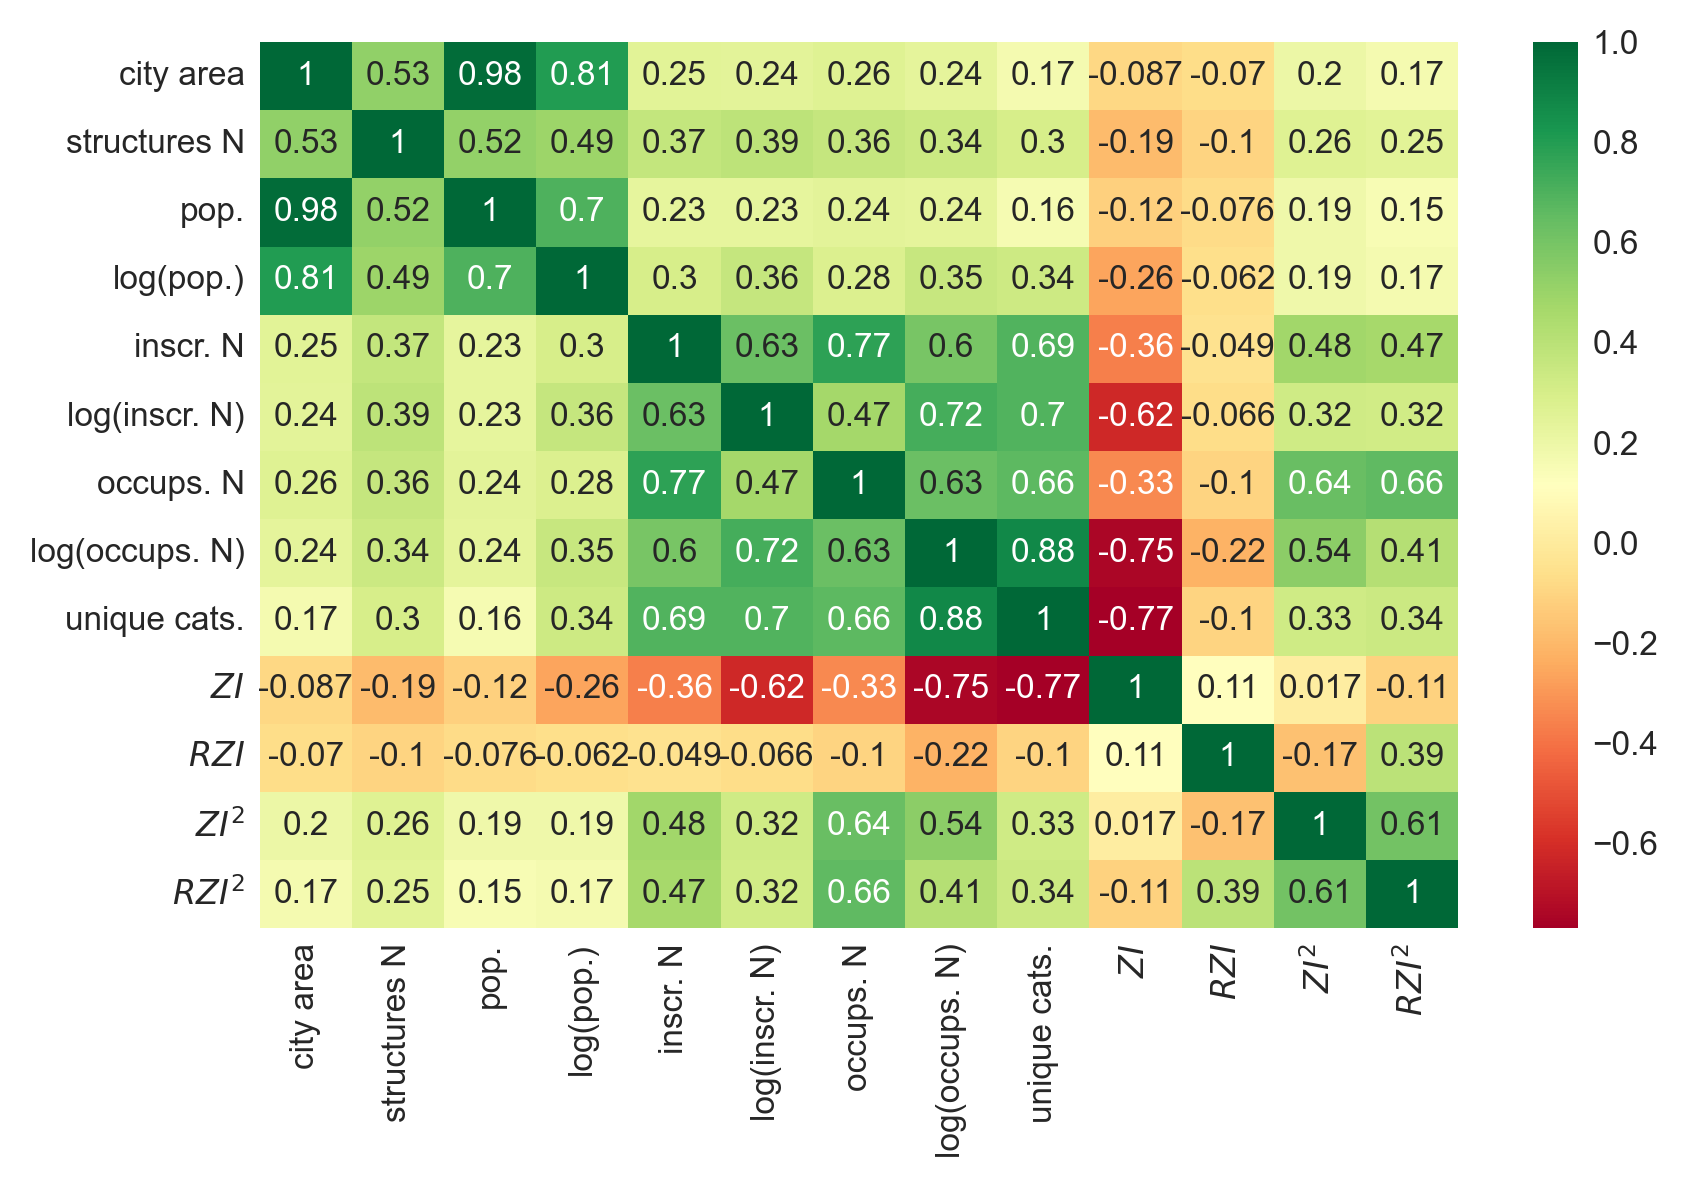

In [75]:
col_labels = ["city area", "structures N", "pop.", "log(pop.)", "inscr. N", "log(inscr. N)", "occups. N", "log(occups. N)", "unique cats.", "$ZI$", "$RZI$", r"$ZI^2$", r"$RZI^2$"]
fig,ax=plt.subplots(tight_layout=True)
sns.heatmap(corr_matrix, xticklabels=col_labels, yticklabels=col_labels, ax=ax, cmap="RdYlGn", annot=True)

In [76]:
save_figure(fig, "specialization_correlation_matrix")

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/specialization_correlation_matrix.eps"
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/specialization_correlation_matrix.png"


# Diversity

In [132]:
# again, the starting point are the shares:
roman_cities_wo["shares_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
165     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
171     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
177     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_vec, Length: 313, dtype: object

In [133]:
def get_di(shares_vec):
    a = np.array(shares_vec)
    a = a**2
    hh = sum(a) # Hirschman-Herfindahl index
    ihh = 1 / hh # inverse Hirschman-Herfindahl index
    return ihh
roman_cities_wo["DI"] = roman_cities_wo["shares_vec"].apply(get_di)
roman_cities_wo["DI"]

159     1.000000
165     3.571429
171     1.975610
174     1.000000
177     1.000000
          ...   
1297    1.000000
1311    1.000000
1315    1.000000
1317    1.000000
1321    1.000000
Name: DI, Length: 313, dtype: float64

In [139]:
roman_cities_wo.sort_values("DI", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N", "DI", "DIw"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,DI,DIw
789,Pompeii,3300.0,56.0,11,7.919192,1.363649
1268,Brigetio,440.0,17.0,9,7.410256,1.812923
785,Norba,106.0,12.0,8,7.200000,2.008389
672,Mogontiacum,3073.0,59.0,12,7.089613,1.205175
1276,Carnuntum (1),1155.0,18.0,10,7.043478,1.689114
...,...,...,...,...,...,...
769,Ferentinum,112.0,4.0,1,1.000000,0.500000
772,Frusino,28.0,5.0,1,1.000000,0.430677
818,Ausculum,12.0,1.0,1,1.000000,0.000000
833,Lupiae,38.0,1.0,1,1.000000,0.000000


In [138]:
def get_diw(a,b):
    if b==0:
        return 0
    else:
        return a / b
roman_cities_wo["DIw"] = roman_cities_wo.apply(lambda row: get_diw(row["DI"], row['occups_N_log']), axis=1)
roman_cities_wo.sort_values("DIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N", "DI", "DIw"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,DI,DIw
1045,Ateste,128.0,6.0,6,6.0,2.321117
1271,Mursa,109.0,6.0,6,6.0,2.321117
1283,Siscia,116.0,5.0,5,5.0,2.153383
1277,Carnuntum (2),354.0,8.0,7,6.4,2.133333
785,Norba,106.0,12.0,8,7.2,2.008389
...,...,...,...,...,...,...
649,Mauves,4.0,1.0,1,1.0,0.000000
631,Aquae Sextiae,24.0,1.0,1,1.0,0.000000
605,Cabillonum,28.0,1.0,1,1.0,0.000000
596,Agedincum,3.0,1.0,1,1.0,0.000000


In [102]:
def get_rdi(shares_vec):
    sij = np.array(shares_vec)
    sj = total_shares
    sij_w = sij - sj
    sij_sum = sum(sij_w) # Hirschman-Herfindahl index
    rdi = 1 / sij_sum # inverse Hirschman-Herfindahl index
    return rdi# rdi
roman_cities_wo["RDI"] = roman_cities_wo["shares_vec"].apply(get_rdi)
roman_cities_wo["RDI"]

159    -2.058788e+16
165     1.601280e+16
171    -1.108578e+16
174    -2.058788e+16
177    -2.058788e+16
            ...     
1297   -2.058788e+16
1311   -2.058788e+16
1315   -2.058788e+16
1317   -2.058788e+16
1321   -2.058788e+16
Name: RDI, Length: 313, dtype: float64

In [103]:
roman_cities_wo["shares_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
165     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
171     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
177     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_vec, Length: 313, dtype: object

In [105]:
roman_cities_wo.sort_values("RDI", ascending=False)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI_cat,shares_weighted_vec,RZI,RZI_cat,shares_squared_vec,ZI2,ZI2_cat,RZI2,DI,RDI
1266,Hanson2016_1267,Aquincum,Obuda,Pannonia Inferior,Hungary,2,20 G2,106,NaN,Boatwright 2000; Golvin 1988; McEvedy 2011; PE...,...,Metal-Working,"[1.5443615257048091, 0.23246138644755315, 2.99...",2.990736,Clothing,"[0.373134328358209, 0.014925373134328358, 2.52...",3.358209,Metal-Working,38.879568,6.367376,1.921536e+17
788,Hanson2016_789,Picentia,Pontecagnano,Italia (I Latium and Campania),Italy,-,-,-400,NaN,Beloch 1880; de Ligt 2012; DGRG; PECS.,...,Managerial,"[0.0, 3.1149825783972123, 0.0, 0.0, 0.0, 0.0, ...",3.114983,Building,"[0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.800000,Managerial,7.597734,2.272727,1.441152e+17
363,Hanson2016_364,Siarum,Torre del Aguila,Baetica,Spain,3,26 E4,-50,NaN,Keay 1998; MacMullen 2000.,...,Performing Arts,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",26.927711,Performing Arts,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.000000,Performing Arts,53.855422,1.000000,1.441152e+17
345,Hanson2016_346,Isturgi,Los Villares,Baetica,Spain,3,27 A3,-50,NaN,MacMullen 2000; Sear 2006.,...,Performing Arts,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",26.927711,Performing Arts,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,Performing Arts,26.927711,1.000000,1.441152e+17
1268,Hanson2016_1269,Brigetio,Szöny,Pannonia Inferior,Hungary,3,20 F2,50,NaN,BNP; DGRG; PECS; Salmon 1969; Wilkes 2003b; Wi...,...,Clothing,"[0.0, 0.0, 2.720081135902637, 0.0, 0.0, 0.0, 0...",4.961154,Plastic Arts,"[0.0, 0.0, 0.5294117647058824, 0.0, 0.0, 0.0, ...",0.529412,Clothing,8.160243,7.410256,1.441152e+17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,Hanson2016_845,Venusia,Venosa,Italia (II Apulia et Calabria),Italy,3,45 C3,-400,NaN,Beloch 1880; Bispham 2007; BNP; Cornell and Ma...,...,Metal-Working,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.47524752...",2.108491,Food-Production,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, ...",0.900000,Metal-Working,4.130390,4.166667,-4.803840e+16
546,Hanson2016_547,Salona,Solin,Dalmatia,Croatia,2,20 D6,-78,NaN,BNP; Bomgardner 2000; Brunt 1971; Cornell and ...,...,Metal-Working,"[0.7760416666666666, 0.5840592334494773, 1.541...",3.991071,Water-Management,"[0.1125, 0.1125, 0.8, 0.0, 0.0125, 0.0125, 0.0...",11.250000,Metal-Working,51.629877,5.245902,-7.205759e+16
1071,Hanson2016_1072,Mediolanum (Italia (XI Transpadana)),Milan,Italia (XI Transpadana),Italy,1,39 E3,-89,NaN,Beloch 1880; Beloch 1886; Benario 1981; de Lig...,...,Managerial,"[0.6785063752276868, 0.25532644085223055, 1.76...",2.902126,Retail,"[0.06557377049180328, 0.01639344262295082, 0.8...",3.688525,Managerial,34.825515,6.212020,-9.607679e+16
968,Hanson2016_969,Clusium,Chiusi,Italia (VII Etruria),Italy,2,42 B2,-500,NaN,Beloch 1880; Bispham 2007; BNP; Cornell and Ma...,...,Metal-Working,"[0.0, 1.5574912891986061, 3.082758620689656, 0...",3.360902,Transport,"[0.0, 0.1, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, ...",0.900000,Metal-Working,6.165517,4.166667,-1.441152e+17


In [106]:
roman_cities_wo_quant = roman_cities_wo[
    roman_cities_wo["Ancient Toponym"]!="Roma"][[
   'Area', 'num_of_structures','pop_est', 'pop_est_log', 'inscr_N',  'inscr_N_log', 'occups_N', 'occups_N_log', 'occups_cats_unique_N',
 'ZI', 'RZI','ZI2',"RZI2", "DI", "RDI"]]

In [116]:
corr_matrix = roman_cities_wo_quant.corr()
corr_matrix = corr_matrix.round(2)
corr_matrix

,Area,num_of_structures,pop_est,pop_est_log,inscr_N,inscr_N_log,occups_N,occups_N_log,occups_cats_unique_N,ZI,RZI,ZI2,RZI2,DI,RDI
Area,1.00,0.53,0.98,0.81,0.25,0.24,0.26,0.24,0.17,-0.09,-0.07,0.20,0.17,0.12,0.03
num_of_structures,0.53,1.00,0.52,0.49,0.37,0.39,0.36,0.34,0.30,-0.19,-0.10,0.26,0.25,0.25,0.03
pop_est,0.98,0.52,1.00,0.70,0.23,0.23,0.24,0.24,0.16,-0.12,-0.08,0.19,0.15,0.13,0.02
pop_est_log,0.81,0.49,0.70,1.00,0.30,0.36,0.28,0.35,0.34,-0.26,-0.06,0.19,0.17,0.31,-0.00
inscr_N,0.25,0.37,0.23,0.30,1.00,0.63,0.77,0.60,0.69,-0.36,-0.05,0.48,0.47,0.54,-0.05
inscr_N_log,0.24,0.39,0.23,0.36,0.63,1.00,0.47,0.72,0.70,-0.62,-0.07,0.32,0.32,0.66,-0.00
occups_N,0.26,0.36,0.24,0.28,0.77,0.47,1.00,0.63,0.66,-0.33,-0.10,0.64,0.66,0.49,-0.03
occups_N_log,0.24,0.34,0.24,0.35,0.60,0.72,0.63,1.00,0.88,-0.75,-0.22,0.54,0.41,0.81,0.04
occups_cats_unique_N,0.17,0.30,0.16,0.34,0.69,0.70,0.66,0.88,1.00,-0.77,-0.10,0.33,0.34,0.93,0.03
ZI,-0.09,-0.19,-0.12,-0.26,-0.36,-0.62,-0.33,-0.75,-0.77,1.00,0.11,0.02,-0.11,-0.88,-0.02


<AxesSubplot:>

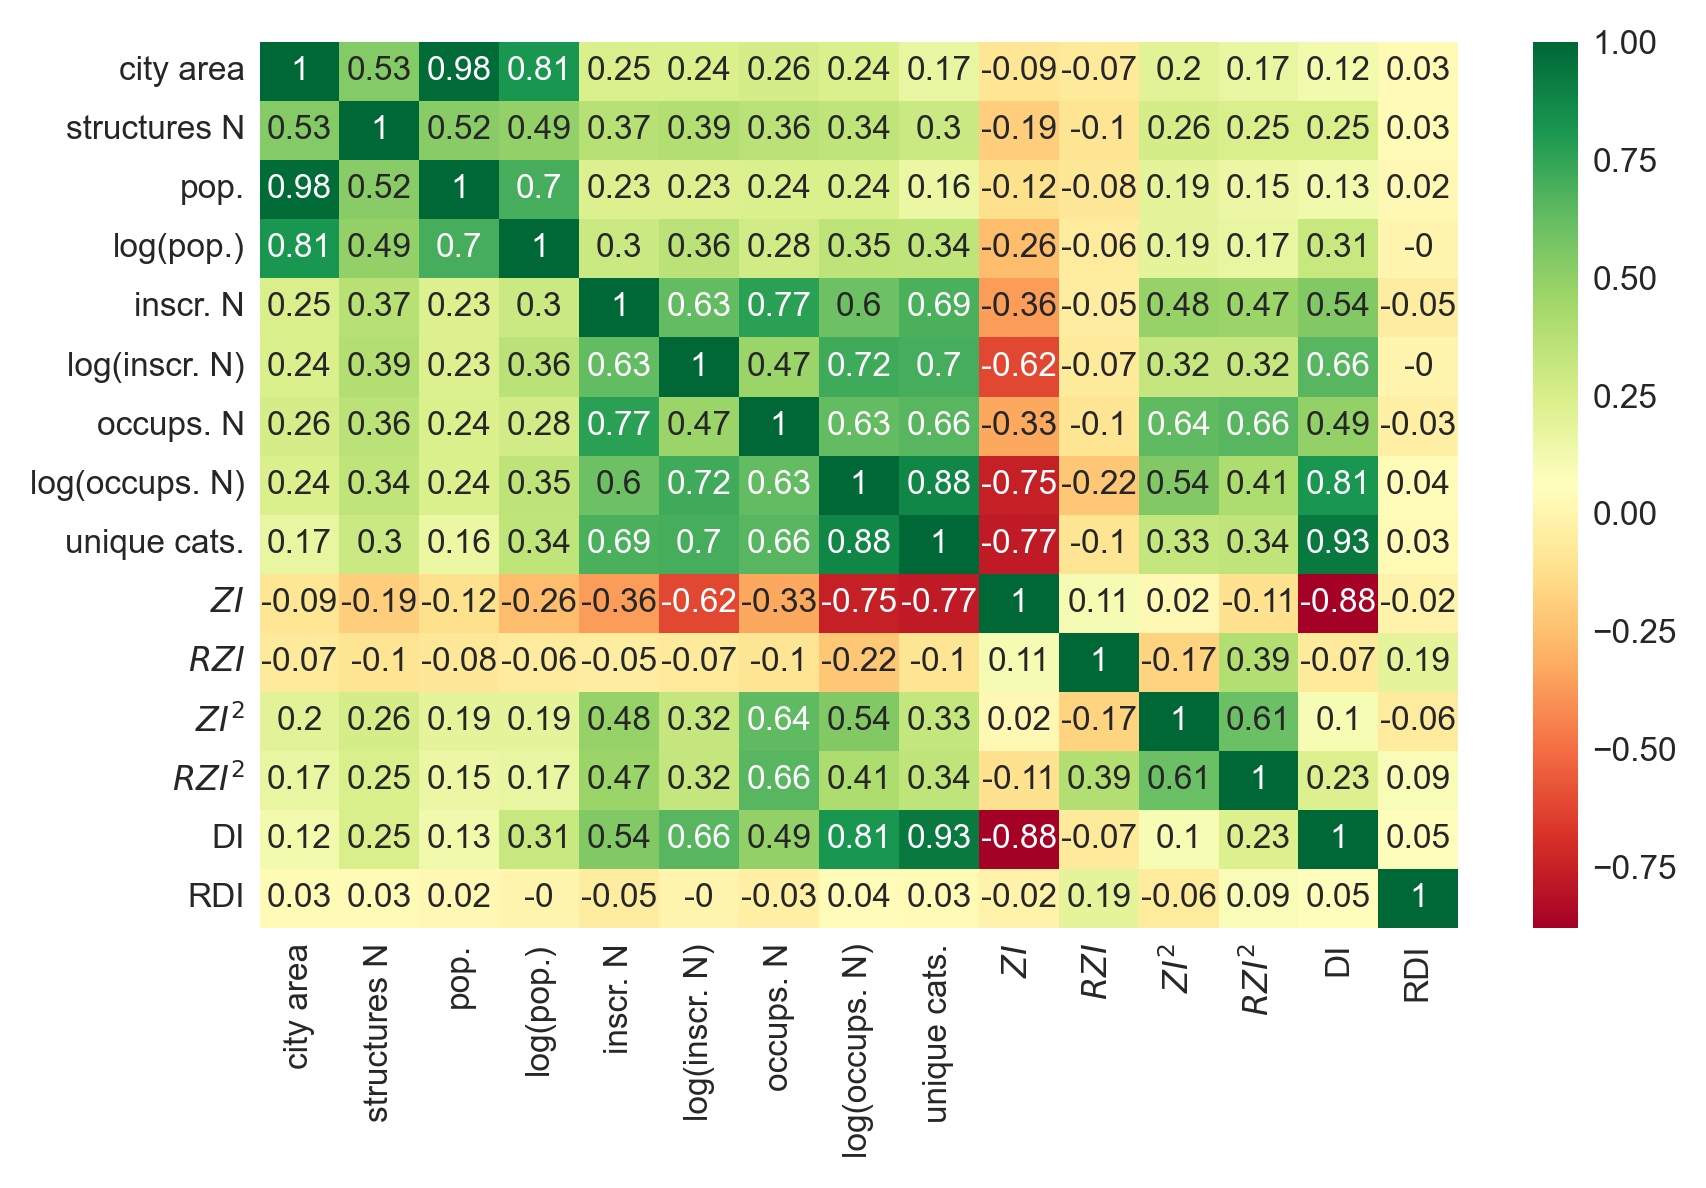

In [117]:
col_labels = ["city area", "structures N", "pop.", "log(pop.)", "inscr. N", "log(inscr. N)", "occups. N", "log(occups. N)", "unique cats.", "$ZI$", "$RZI$", r"$ZI^2$", r"$RZI^2$", "DI", "RDI"]
fig,ax=plt.subplots(tight_layout=True)
sns.heatmap(corr_matrix, xticklabels=col_labels, yticklabels=col_labels, ax=ax, cmap="RdYlGn", annot=True)